[![taxi.png](https://i.postimg.cc/kXw5dQW3/taxi.png)](https://postimg.cc/8jJGRryt)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование заказов такси</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Компания «Чётенькое такси».
    
__Постановка задачи:__ Для привлечения водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построив модель.
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики RMSE на тестовой выборке должно быть не больше 48.
    
__Описание данных:__ Исторические данные о заказах такси в аэропортах
    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
! pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [3]:
# загрузка данных:
try:
    df = pd.read_csv('datasets/taxi.csv')
    display(df.head(2))
except:
    display('Данные не доступны')

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

__Проверим пропуски в данных:__

In [5]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [6]:
print(f'Общее количество дубликатов в данных: {df.duplicated().sum()}')

Общее количество дубликатов в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
- Дублитакы в данных отсутствуют.
    
__Недостатки:__
- Признак `datetime` представлен в типе object, следует изменить на datetime64
    
</div>

__Обработка типов данных:__

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

__Установка индекса таблицы равным столбцу `datetime` и отсортируем по возрастанию:__

In [8]:
df = df.set_index('datetime')
df = df.sort_index(ascending=True)
display(df.head(2))
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ и обработка данных
    
</div>

__Проверим хронологический порядок данных:__

In [9]:
if df.index.is_monotonic_increasing:
    print('Данные представлены в хронологическом порядке')
else: print('Хронологический порядок в данных нарушен')

Данные представлены в хронологическом порядке


In [10]:
print(f'Данные представленны в промежутке от {df.index.min()} до {df.index.max()}')

Данные представленны в промежутке от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


In [11]:
# т.к. данные представлены в хронологическом порядке используем срезнее значение
print(f'Интервала между наблюдениями составляет: {df.index.to_series().diff().mean()}')

Интервала между наблюдениями составляет: 0 days 00:10:00


- Интервал между наблюдениями составляет 10 минут, тк перед нами стоит задача спрогнозировать количество заказов такси на следующий час, проведем ресемплирование, и объединим записи в промежутке одного часа и рассчитаем сумму заказов такси, за это время

In [12]:
df = df.resample('1D').sum()

### Визуализация временного ряда
- Посмотрим на тренд и сезонность всего временного ряда
- Визуализируем данные за последний месяц

__Визуализация всех данных__

<function matplotlib.pyplot.show(close=None, block=None)>

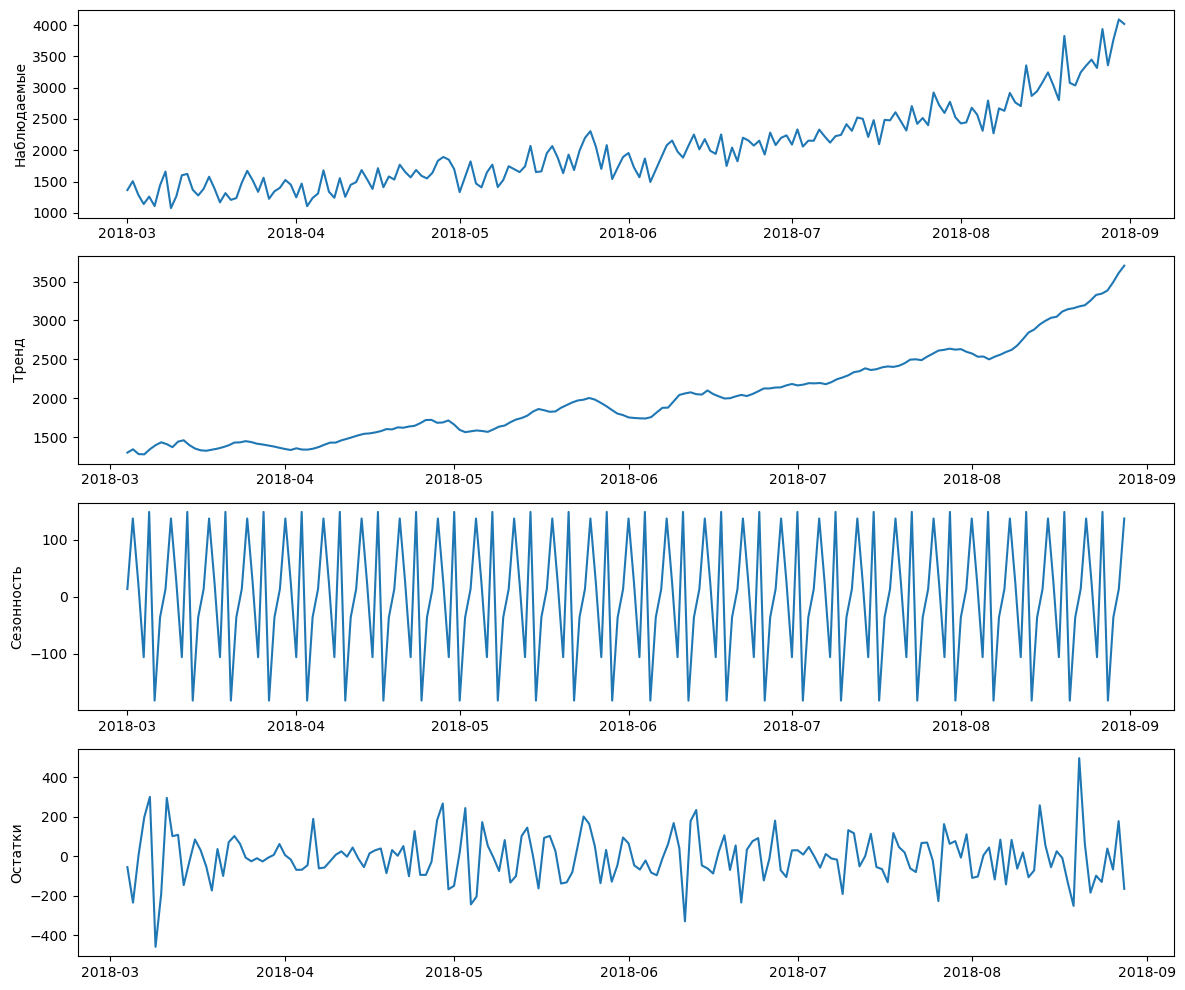

In [16]:
decomposition = seasonal_decompose(df)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(df.index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(df.index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

__Визуализация наблюдений за последний месяц__

<function matplotlib.pyplot.show(close=None, block=None)>

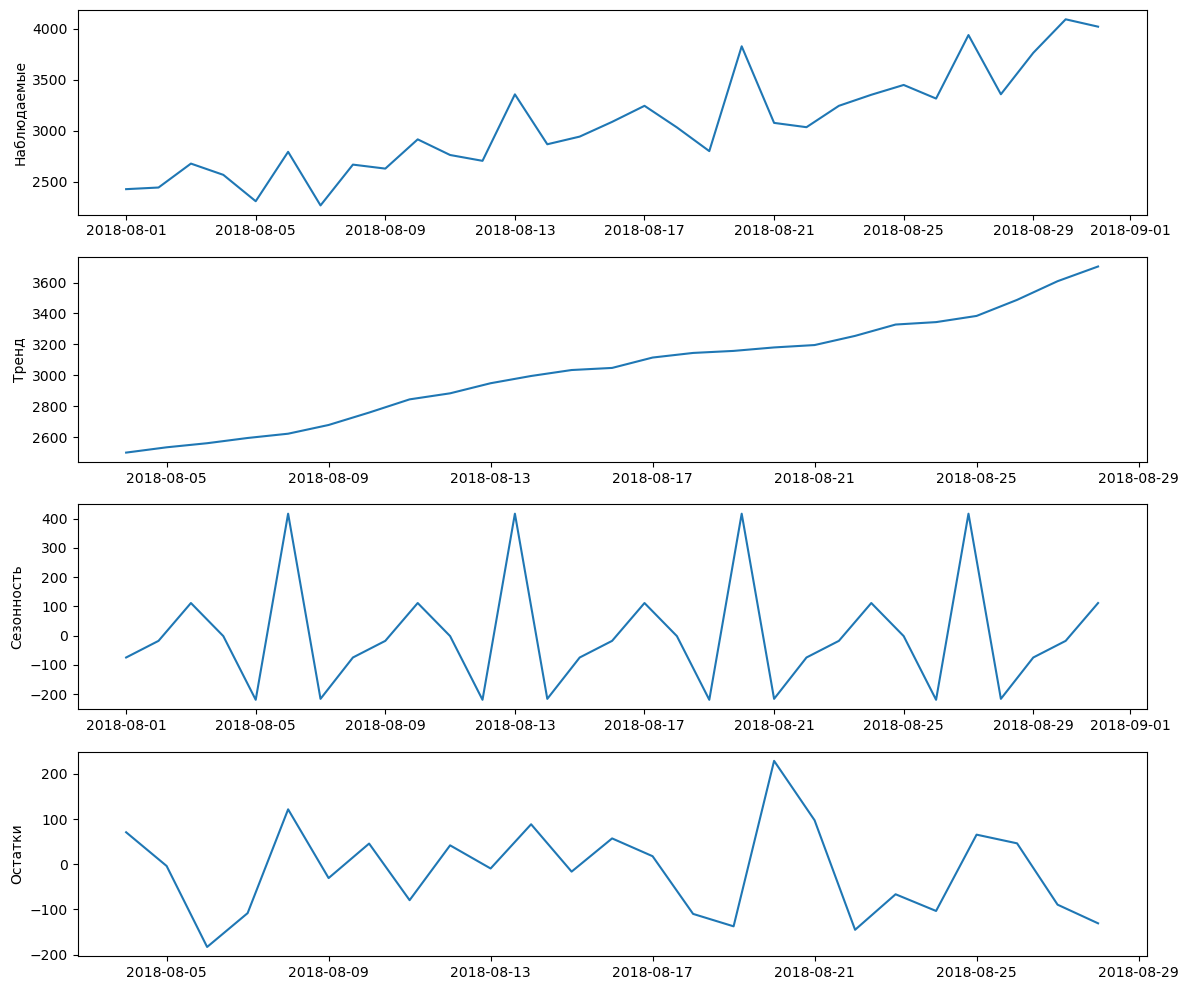

In [18]:
decomposition = seasonal_decompose(df['2018-08':'2018-08'])

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(df['2018-08':'2018-08'].index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(df['2018-08':'2018-08'].index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(df['2018-08':'2018-08'].index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(df['2018-08':'2018-08'].index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

<div style="padding: 30px 25px; border: 2px #6495ed solid">

- По общему тренду видно, увеличение количества заказов такси, в аэропортах, к летнему сезену, по сравнению с зимним.
- В месячном промежутке, наблюдается сезонность с недельной периодичностью.
    
</div>

### Стационарность  временного ряда
- Найдём скользящее стандартное отклонение

<Axes: xlabel='datetime'>

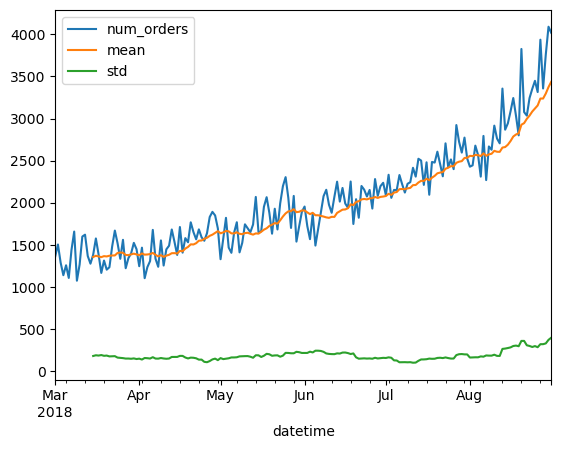

In [19]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot() 

- Временной ряд не является стационарным, потому что у него меняется среднее значение.

### Разности временного ряда

<Axes: xlabel='datetime'>

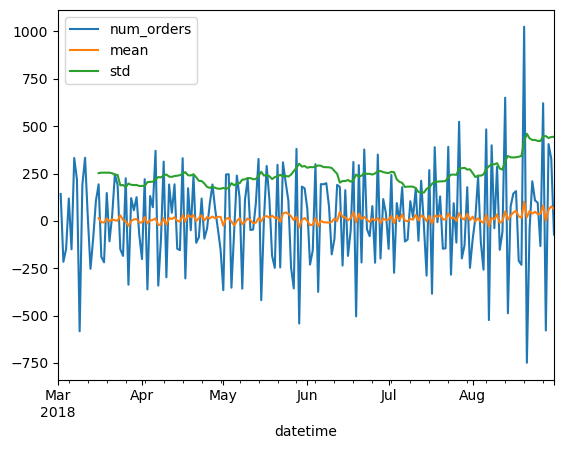

In [20]:
df['num_orders'] = df['num_orders'] - df['num_orders'].shift()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot() 

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Тренд временного ряда при разности значений стал нулевым
- Одноко, данные стали более стационарны, как следствие, их можно прогнозировать
    
</div>

## Обучение

## Тестирование

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48